# HomeWork 13

**DeadLine : 23:59 4 Day 1399**

**Total points : 100pts**

Import some prerequisites:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import os
import math

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Run this cell for plotting evaluation.

In [3]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and F1-score and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for', title, '=', acc)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    print('F1 score for', title, '=', f1)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

Here is for your helper functions(optional)

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Input, BatchNormalization,concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.datasets import fashion_mnist

Getting the data:

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Data augmentation:

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([1],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])
    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape(tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3])
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    return(rotation_matrix)

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = image.shape[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 12. * tf.random.normal([1],dtype='float32')
    shr = 30. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 10. * tf.random.normal([1],dtype='float32') 
    w_shift = 20. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.keras.backend.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = tf.keras.backend.cast(idx2,dtype='int32')
    idx2 = tf.keras.backend.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,1]),label

def data_augment(image,label):
    #image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    #image = tf.image.resize_with_crop_or_pad(image, 35, 35) # Add 6 pixels of padding
    #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28    
    image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness

    return(image,label)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 256

In [ ]:
train_dataset_augment = (
    tf.data.Dataset
    .from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
    .map(data_augment, num_parallel_calls=AUTO)
    .map(transform, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTO)
)

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
    .repeat()
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test.astype(np.float32))
    .batch(batch_size)
)

In [ ]:
x_val = x_train[48000:]
y_val = y_train[48000:]
x_train = x_train[:48000]
y_train = y_train[:48000]

# Activating TPU:

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.100.160.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.100.160.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.160.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Best Model

Create your model.

In [83]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

def create_model(): 
  # define model input
  visible = Input(shape=(28, 28, 1))
  # add inception block 1
  layer = BatchNormalization()(visible)
  layer = inception_module(layer, 16, 16, 32, 32, 64, 64)
  layer = Dropout(0.25)(layer)
  # add inception block 2
  # layer = BatchNormalization()(layer)
  layer = inception_module(layer, 128, 128, 192, 192, 224, 224)
  layer = Dropout(0.25)(layer)
  # # add inception block 3
  # layer = BatchNormalization()(layer)
  # layer = inception_module(layer, 224, 224, 256, 256, 278, 278)
  # layer = Dropout(0.25)(layer)
  # create model
  layer = Flatten()(layer)
  layer = Dense(128, activation='relu')(layer)
  layer = Dense(10, activation='softmax')(layer)
  model = Model(inputs=visible, outputs=layer)

  # model.add(BatchNormalization(input_shape=x_train.shape[1:]))
  # model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  # model.add(Dropout(0.25))

  # model.add(BatchNormalization(input_shape=x_train.shape[1:]))
  # model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.25))

  # model.add(BatchNormalization(input_shape=x_train.shape[1:]))
  # model.add(Conv2D(256, (5, 5), padding='same', activation='elu'))
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  # model.add(Dropout(0.25))

  # model.add(Flatten())
  # model.add(Dense(256,activation='relu'))
  # # model.add(Activation('elu'))
  # model.add(Dropout(0.5))
  # model.add(Dense(10,activation='softmax'))
  # model.add(Activation('softmax'))
  model.compile(loss="categorical_crossentropy", experimental_steps_per_execution = 50,optimizer='adam',metrics=['accuracy'])
  return model

In [84]:
with tpu_strategy.scope():
  model = create_model()

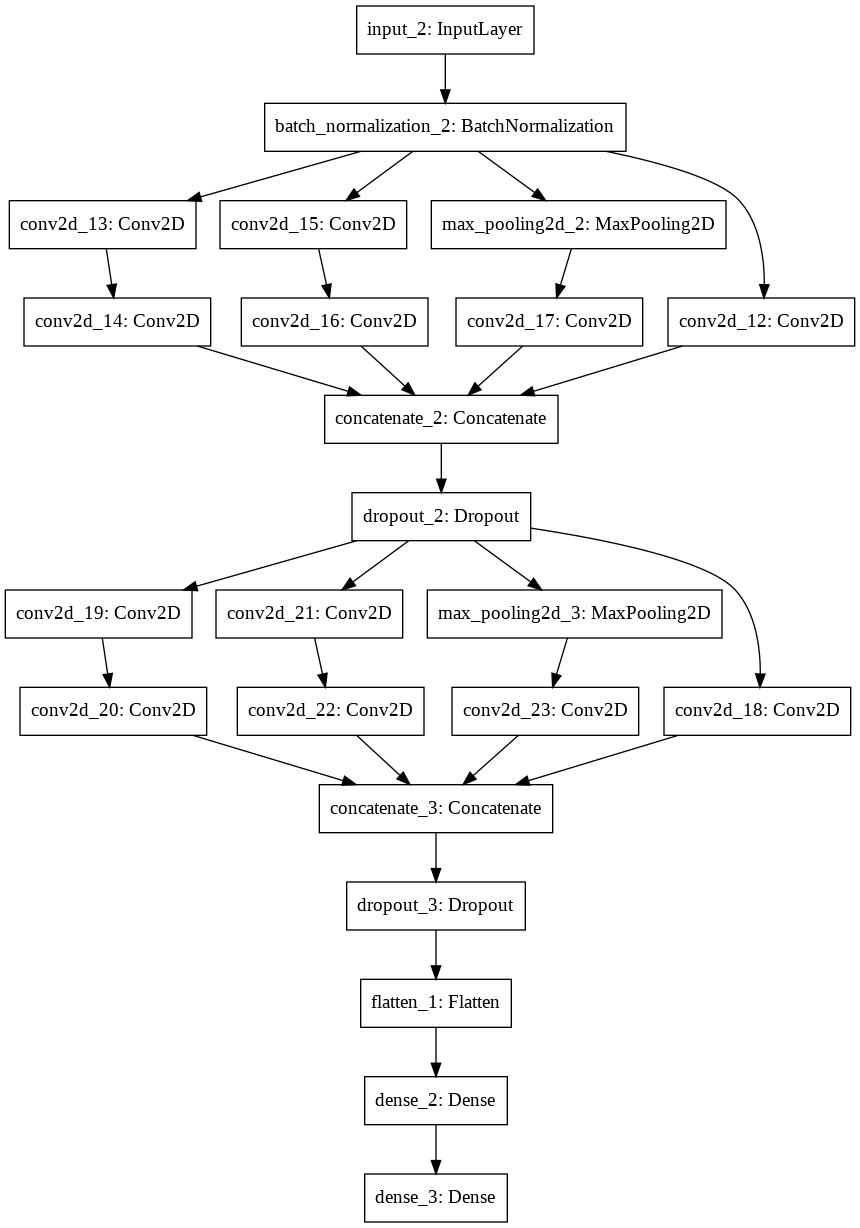

In [88]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

Train your model.

In [85]:
model.fit(x_train.astype(np.float32),y_train.astype(np.float32),
                  epochs=22,
                  steps_per_epoch=60,
                  verbose=1,validation_split=0.2)

Epoch 1/22
60/60 [==============================] - 36s 603ms/step - loss: 2.5265 - accuracy: 0.6927 - val_loss: 0.4694 - val_accuracy: 0.8286
Epoch 2/22
60/60 [==============================] - 6s 108ms/step - loss: 0.3648 - accuracy: 0.8699 - val_loss: 0.3607 - val_accuracy: 0.8743
Epoch 3/22
60/60 [==============================] - 6s 108ms/step - loss: 0.3018 - accuracy: 0.8925 - val_loss: 0.3211 - val_accuracy: 0.8916
Epoch 4/22
60/60 [==============================] - 6s 108ms/step - loss: 0.2613 - accuracy: 0.9069 - val_loss: 0.2987 - val_accuracy: 0.8993
Epoch 5/22
60/60 [==============================] - 6s 108ms/step - loss: 0.2355 - accuracy: 0.9138 - val_loss: 0.2856 - val_accuracy: 0.9028
Epoch 6/22
60/60 [==============================] - 6s 108ms/step - loss: 0.2155 - accuracy: 0.9227 - val_loss: 0.2816 - val_accuracy: 0.9012
Epoch 7/22
60/60 [==============================] - 6s 107ms/step - loss: 0.1964 - accuracy: 0.9297 - val_loss: 0.2585 - val_accuracy: 0.9097
Epoch

In [ ]:
model.fit(train_dataset_augment,
                  epochs=20,
                  steps_per_epoch=60,
                  verbose=1,validation_data=val_dataset)

# Evaluation

Evaluate your model

Accuracy for Fashion MNIST Classifier = 0.9089
F1 score for Fashion MNIST Classifier = 0.9083681981726747


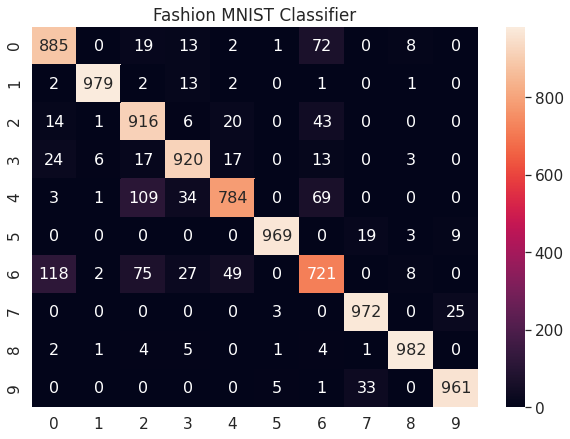

In [89]:
# Suggestion: Using the evaluation function.
# Get y_pred for y_test from model.predict() then use evaluation(y_test, y_pred, fig_name, title)
# with proper name for fig_name and title.
y_pred = model.predict(x_test.astype(np.float32))
y_pred = np.array([x.argmax() for x in y_pred])
y_test_2 = np.array([x.argmax() for x in y_test])
evaluation(y_test_2,y_pred,"confusion","Fashion MNIST Classifier")

In [90]:
# Suggestion: Using the plotter function.
model.evaluate(x_test.astype(np.float32),y_test.astype(np.float32))

313/313 [==============================] - 8s 27ms/step - loss: 0.3142 - accuracy: 0.9089


[0.3142355978488922, 0.9088999629020691]

Show 10 bad loss images.

In [91]:
pred = model.predict(x_test.astype(np.float32))

In [92]:
a = [(p.max(),i,y_test[i].argmax(),p.argmax()) for i,p in enumerate(pred) if p.argmax() != y_test[i].argmax()]

In [93]:
sorted_a = sorted(a, key=lambda tup: tup[0])
sorted_a.reverse()

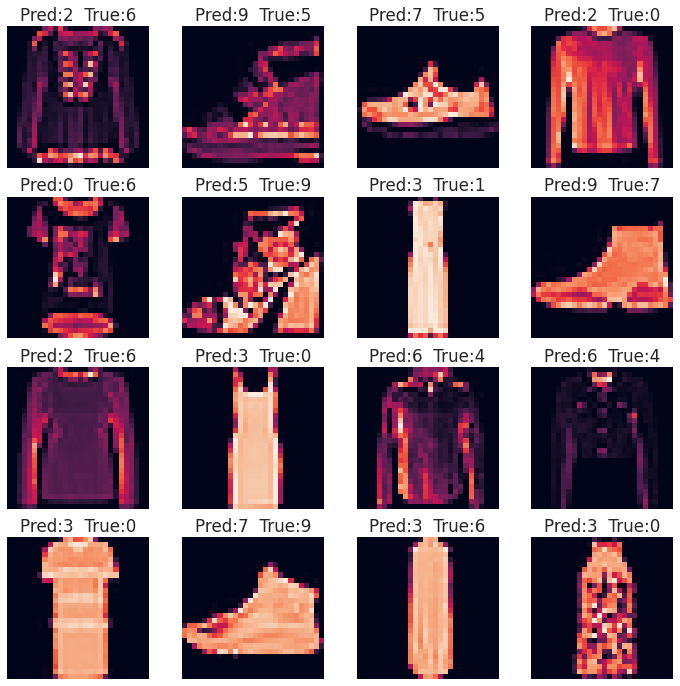

In [94]:
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i,ax in enumerate(axes.flat):
  ax.axis('off')
  ax.set_title(f"Pred:{sorted_a[i][3]}  True:{sorted_a[i][2]}")
  ax.imshow(np.squeeze(x_test[sorted_a[i][1]]))

End!!!